In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.python.framework import ops
import math
import os

In [24]:
tf.__version__

'1.4.0'

In [25]:
img_size = 32
img_channels = 3
img_shape = [img_channels, img_size, img_size]
num_classes = 10

In [26]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i,...], interpolation="nearest")

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [27]:
datadir = "/mnt/hdisk/dataset/cifar-10-batches-py/"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True 

In [28]:
def load_batch(file):
    """
    load a batch in the CIFAR-10 format
    """
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo,encoding='bytes')
    return dict[b'data'],dict[b'labels']

In [29]:
def load_cifar10():
    """
    load the CIFAR10 datasets
    :return:
    """
    x_train=[]
    y_train=[]
    for k in range(5):
        data,labels=load_batch(datadir+"data_batch_%d"%(k+1))
        # labels is list
        # data is array
        data=data.reshape(10000,img_channels,img_size,img_size).transpose(0,2,3,1).astype("float")
        labels=np.array(labels)
        x_train.append(data)
        y_train.append(labels)

    x_train=np.concatenate(x_train,axis=0)
    y_train=np.concatenate(y_train,axis=0)

    # test
    x_test, y_test=load_batch(datadir+"test_batch")
    x_test = x_test.reshape(10000,img_channels,img_size,img_size).transpose(0,2,3,1).astype("float")
    y_test = np.array(y_test)

    return x_train, y_train, x_test, y_test

In [30]:
# 加载训练和测试的图片文件
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig=load_cifar10()

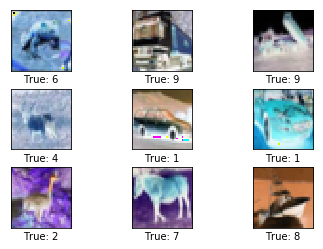

In [31]:
# 显示一部分图片
images_show = X_train_orig[0:9]
cls_true = Y_train_orig[0:9]
plot_images(images=images_show,cls_true=cls_true)


In [32]:
def one_hot_matrix(labels, C):
    """
    Generate the one-hot encoded class-labels from an array of integers.
    For example, if class_number=2 and num_classes=4 the
    the one-hot encoded label is the float array:[0. 0. 1. 0.]
    """
    if C is None:
        C = np.max(labels)+1

    return np.eye(C, dtype=float)[labels]

In [33]:
def print_activations(t):
    print("tensor param: {}, {}".format(t.op.name,t.get_shape().as_list()))

In [34]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    creates the placeholders for the tensorflow session.
    """
    X=tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0])
    Y=tf.placeholder(tf.float32,[None,n_y])

    return X,Y

In [44]:
def initialize_parameters():
    """
    initializes weight parameters to build a neural network with tensorflow.
    """
    # layer 1
    # strides[1,1,1,1]
    # max pool ksize=[1,3,3,1] strides=[1,3,3,1]
    W1 = tf.get_variable("W1",[5,5,3,64],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b1 = tf.get_variable("b1",[64],initializer=tf.zeros_initializer)
    W1_reg = tf.nn.l2_loss(W1)
    
    # layer 2
    # strides[1,1,1,1]
    # max pool ksize=[1,3,3,1] strides=[1,3,3,1]
    W2 = tf.get_variable("W2",[5,5,64,64],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b2 = tf.get_variable("b2",[W2.get_shape()[3].value],initializer=tf.zeros_initializer)
    W2_reg = tf.nn.l2_loss(W2)
    
    # layer 3
    # strides[1,1,1,1]
    W3 = tf.get_variable("W3",[3,3,64,384],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b3 = tf.get_variable("b3",[384],initializer=tf.zeros_initializer)
    W3_reg = tf.nn.l2_loss(W3)
    
    # layer 4
    # strides[1,1,1,1]
    # max pool ksize=[1,3,3,1] strides=[1,2,2,1]
    W4 = tf.get_variable("W4",[3,3,384,256],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b4 = tf.get_variable("b4",[256],initializer=tf.zeros_initializer)
    W4_reg = tf.nn.l2_loss(W4)
    
    parameters={"W1":W1,
                "b1":b1,
                "W1_reg":W1_reg,
                "W2":W2,
                "b2":b2,
                "W2_reg":W2_reg,
                "W3":W3,
                "b3":b3,
                "W3_reg":W3_reg,
                "W4":W4,
                "b4":b4,
                "W4_reg":W4_reg}

    return parameters

In [36]:
def slice_mini_batches(X,Y,mini_batch_size=64):
    
    m = X.shape[0]
    mini_batches=[]

    # partition
    num_complete_minibatches = int(m/mini_batch_size)

    for k in range(0,num_complete_minibatches):
        mini_batch_X = X[k*mini_batch_size:(k+1)*mini_batch_size,...]
        mini_batch_Y = Y[k*mini_batch_size:(k+1)*mini_batch_size,:]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        end = int(mini_batch_size*math.floor(m/mini_batch_size))
        mini_batch_X = X[end:m,...]
        mini_batch_Y = Y[end:m,:]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [37]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    """
    Create a list of random minibatches from (X,Y)
    """
    np.random.seed(seed)
    m = X.shape[0]
    mini_batches=[]

    # shuffle
    permutation=list(np.random.permutation(m))
    shuffled_X=X[permutation,...]
    shuffled_Y=Y[permutation,:]

    return slice_mini_batches(shuffled_X,shuffled_Y,mini_batch_size)

In [38]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D->RELU->MAXPOOL->FALTTEN->FULLYCONNECTED
    """
    
    # layer 1
    W1=parameters["W1"]
    b1=parameters["b1"]
    # CONV2D
    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    Z1 = tf.nn.bias_add(Z1,b1)
    # RELU
    A1=tf.nn.relu(Z1)
    # MAXPOOL
    P1=tf.nn.max_pool(A1,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME", name="pool1")
    print_activations(P1)
    # TODO: 添加batch normalization
    # TODO: 添加L2正则化weight decay
    
    # layer 2
    W2=parameters["W2"]
    b2=parameters["b2"]
    # CONV2D
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    Z2 = tf.nn.bias_add(Z2,b2)
    # ReLU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL
    P2 = tf.nn.max_pool(A2,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")
    print_activations(P2)
    
    # layer 3
    W3=parameters["W3"]
    b3=parameters["b3"]
    # CONV2D
    Z3 = tf.nn.conv2d(P2,W3,strides=[1,1,1,1],padding="SAME")
    Z3 = tf.nn.bias_add(Z3,b3)
    # ReLU
    P3 = tf.nn.relu(Z3)
    print_activations(P3)
    
    # layer 4
    W4=parameters["W4"]
    b4=parameters["b4"]
    # CONV2D
    Z4 = tf.nn.conv2d(P3,W4,strides=[1,1,1,1],padding="SAME")
    Z4 = tf.nn.bias_add(Z4,b4)
    # ReLU
    A4 = tf.nn.relu(Z3)
    # Max Pool
    P4 = tf.nn.max_pool(A4,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")
    print_activations(P4)
    
    
    # FLATTEN
    P=tf.contrib.layers.flatten(P4)

    # Fully connected layer
    # activation_fn默认tf.nn.relu
    F1=tf.contrib.layers.fully_connected(P,512)
    F2=tf.contrib.layers.fully_connected(F1,256)
    F3=tf.contrib.layers.fully_connected(F2,num_classes,activation_fn=None)
    
    return F3

In [39]:
def compute_cost(F3,Y,parameters):
    """
    Compute the cost
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=F3,labels=Y))
    
    # 添加了正则化项，但是具体效果还需要检验
    # L1正则化
    W1_reg = parameters["W1_reg"]
    W2_reg = parameters["W2_reg"]
    W3_reg = parameters["W3_reg"]
    W4_reg = parameters["W4_reg"]
    
    regularizers = W1_reg + W2_reg + W3_reg + W4_reg
    
    cost = tf.reduce_mean(cost + 0.09 * regularizers)

    return cost

In [40]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64):
    """
    Implements a three-layer ConvNet in tensorflow
    """
    ops.reset_default_graph()

    seed = 3

    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=Y_train.shape[1]

    costs=[]
    train_accuracys=[]
    test_accuracys=[]

    # create placeholders of the correct shape
    X, Y=create_placeholders(n_H0,n_W0,n_C0,n_y)

    parameters=initialize_parameters()

    Y_hat = forward_propagation(X, parameters)

    cost = compute_cost(Y_hat,Y,parameters)

    # Backpropagation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    init = tf.global_variables_initializer()


    # Start the session to compute the tensorflow graph

    # calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Y_hat, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver()
    save_dir = "checkpoints/"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir,'train_param')
    
    with tf.Session(config=config) as sess:
        # run the initialization
        sess.run(init)

        # Do the train loop
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            # number of minibatches of size minibatch_size in the train set
            num_minibatches=math.floor(m/minibatch_size)
            seed = seed+1

            minibatches = random_mini_batches(X_train,Y_train,minibatch_size,seed)

            for minibatch in minibatches:
                 # select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})

                minibatch_cost += temp_cost/num_minibatches

            if epoch % 1 ==0:
                costs.append(minibatch_cost)
                print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                
                train_accuracy = 0.
                mini_batch_number = X_train.shape[0]/100;
                train_mini_batches = slice_mini_batches(X_train,Y_train,mini_batch_size=100)
                for mini_batch in train_mini_batches:
                    (X_mini_batch, Y_mini_batch) = mini_batch
                    train_accuracy += sess.run(accuracy,feed_dict={X:X_mini_batch, Y:Y_mini_batch})
                train_accuracy = train_accuracy/mini_batch_number
                train_accuracys.append(train_accuracy)
                
                test_accuracy = 0.
                mini_batch_number = X_test.shape[0]/100;
                test_mini_batches = slice_mini_batches(X_test,Y_test,mini_batch_size=100)
                for mini_batch in test_mini_batches:
                    (X_mini_batch, Y_mini_batch) = mini_batch
                    test_accuracy += sess.run(accuracy,feed_dict={X:X_mini_batch, Y:Y_mini_batch})
                test_accuracy = test_accuracy/mini_batch_number
                test_accuracys.append(test_accuracy)
                
                print("Train accuracy {}, Test accuracy {}".format(train_accuracy,test_accuracy))
                
            if epoch % 3 == 0:
                saver.save(sess=sess, save_path=save_path)
                

        # plot the cost
        plt.subplot(2,1,1)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per epoch)')
        plt.title("Learning rate={}, banch size={}".format(learning_rate,minibatch_size))
        
        plt.subplot(2,1,2)
        plt.plot(np.squeeze(train_accuracys),label="train")
        plt.plot(np.squeeze(test_accuracys),label="test")
        plt.ylabel('accuracy')
        plt.xlabel('iterations')
        plt.title("accuracy iterations")
        
        plt.show()

    return train_accuracy, test_accuracy, parameters

In [41]:
###########################
X_train=X_train_orig/255.
X_test=X_test_orig/255.
Y_train=one_hot_matrix(Y_train_orig,C=10)
Y_test=one_hot_matrix(Y_test_orig,C=10)

In [42]:
print("training dataset X:size({}), type({})".format(X_train.shape,type(X_train)))
print("training dataset Y:size({}), type({})".format(Y_train.shape,type(Y_train)))
print("testing dataset X:size({}), type({})".format(X_test.shape,type(X_test)))
print("testing dataset Y:size({}), type({})".format(Y_test.shape,type(Y_test)))

training dataset X:size((50000, 32, 32, 3)), type(<class 'numpy.ndarray'>)
training dataset Y:size((50000, 10)), type(<class 'numpy.ndarray'>)
testing dataset X:size((10000, 32, 32, 3)), type(<class 'numpy.ndarray'>)
testing dataset Y:size((10000, 10)), type(<class 'numpy.ndarray'>)


tensor param: pool1, [None, 16, 16, 64]
tensor param: MaxPool, [None, 8, 8, 64]
tensor param: Relu_2, [None, 8, 8, 384]
tensor param: MaxPool_1, [None, 4, 4, 384]
Cost after epoch 0: 2.215485
Train accuracy 0.36142000019550324, Test accuracy 0.363800000846386
Cost after epoch 1: 1.655703
Train accuracy 0.4335999977588654, Test accuracy 0.43229999870061875
Cost after epoch 2: 1.540486
Train accuracy 0.4843799971938133, Test accuracy 0.478499998152256
Cost after epoch 3: 1.484804
Train accuracy 0.5104599967598915, Test accuracy 0.508799996972084
Cost after epoch 4: 1.432325
Train accuracy 0.539139997124672, Test accuracy 0.5318999952077865
Cost after epoch 5: 1.393798
Train accuracy 0.539399995803833, Test accuracy 0.5314999991655349
Cost after epoch 6: 1.358946
Train accuracy 0.5515199979543686, Test accuracy 0.5426999971270561
Cost after epoch 7: 1.333737
Train accuracy 0.5701999980807304, Test accuracy 0.5552999976277352
Cost after epoch 8: 1.309054
Train accuracy 0.5498999972343445, 

Train accuracy 0.8445399988889695, Test accuracy 0.6407000023126602
Cost after epoch 83: 0.603197
Train accuracy 0.869220000743866, Test accuracy 0.6430999994277954
Cost after epoch 84: 0.609351
Train accuracy 0.8601799986362457, Test accuracy 0.6426999980211258
Cost after epoch 85: 0.592551
Train accuracy 0.8393399986028671, Test accuracy 0.6398000031709671
Cost after epoch 86: 0.587770
Train accuracy 0.8626599991321564, Test accuracy 0.6269000026583672
Cost after epoch 87: 0.592490
Train accuracy 0.8390599986314774, Test accuracy 0.6147000014781951
Cost after epoch 88: 0.584170
Train accuracy 0.8784399991035461, Test accuracy 0.6421000003814697
Cost after epoch 89: 0.566699
Train accuracy 0.8874400012493133, Test accuracy 0.6356999999284745
Cost after epoch 90: 0.562621
Train accuracy 0.8993000013828277, Test accuracy 0.6489999973773957
Cost after epoch 91: 0.565468
Train accuracy 0.8492799999713898, Test accuracy 0.6275000017881394
Cost after epoch 92: 0.574654
Train accuracy 0.8999

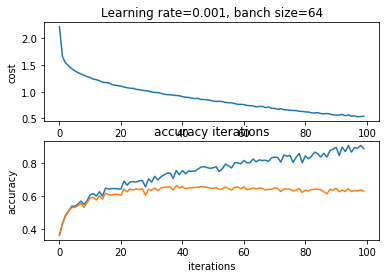

In [45]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test,0.001,100,64)